In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [10]:
# -----------------------------
# Cargar datos
# -----------------------------
model_csv = "results_neuroback.csv"
default_csv = "results_default.csv"

model = pd.read_csv(model_csv)
default = pd.read_csv(default_csv)

print("NeuroBack rows:", len(model))
print("Default rows:", len(default))

NeuroBack rows: 1915
Default rows: 1915


In [11]:
# -----------------------------
# Fusionar por nombre de instancia
# -----------------------------
merged = model.merge(default, on="cnf_name", suffixes=("_model", "_default"))
print("Merged rows:", len(merged))


Merged rows: 1915


In [12]:
# -----------------------------
# Calcular métricas clave
# -----------------------------

# Speedup: cuánto más rápido es el modelo
merged["speedup"] = merged["solving_time_sec_default"] / merged["solving_time_sec_model"].replace(0, np.nan)

# Win: modelo más rápido que default
merged["model_win"] = (merged["solving_time_sec_model"] < merged["solving_time_sec_default"]).astype(int)

# Filtrar instancias correctamente resueltas por ambos
mask_ok_model = merged["result_model"].isin(["SAT", "UNSAT"])
mask_ok_default = merged["result_default"].isin(["SAT", "UNSAT"])
merged_clean = merged[mask_ok_model & mask_ok_default]


In [13]:
# -----------------------------
# Resumen global
# -----------------------------
print("\n=== MÉTRICAS GLOBALES ===")
print("Total instancias:", len(merged))

print("SAT Model       :", sum(merged['result_model'] == 'SAT'))
print("UNSAT Model     :", sum(merged['result_model'] == 'UNSAT'))
print("NO_BACKBONE     :", sum(merged['result_model'] == 'NO_BACKBONE'))

print("\nAVG time Model  :", merged['solving_time_sec_model'].mean())
print("AVG time Default:", merged['solving_time_sec_default'].mean())

print("\nSpeedup promedio (solo resueltas):", merged_clean['speedup'].mean())
print("Modelo gana en     :", merged['model_win'].sum(), "instancias")
print("Baseline gana en   :", len(merged) - merged['model_win'].sum())


=== MÉTRICAS GLOBALES ===
Total instancias: 1915
SAT Model       : 0
UNSAT Model     : 0
NO_BACKBONE     : 1915

AVG time Model  : 0.0
AVG time Default: 0.03316331893283451

Speedup promedio (solo resueltas): nan
Modelo gana en     : 1915 instancias
Baseline gana en   : 0



Generando gráficos...


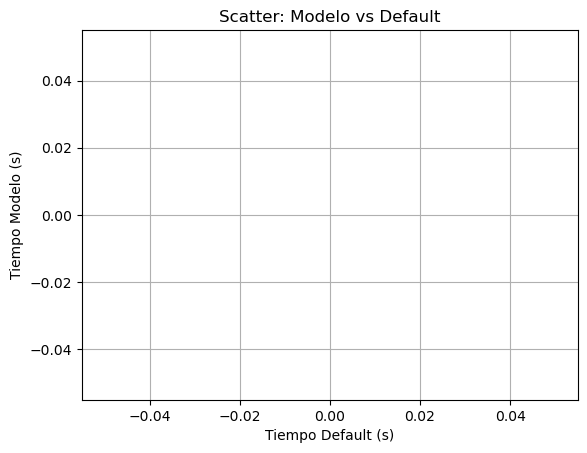

In [16]:
# =======================================================
# =================== GRÁFICOS ==========================
# =======================================================

print("\nGenerando gráficos...")

# -------------------------------------------------------
# Scatter: tiempo modelo vs default
# -------------------------------------------------------
plt.figure()
plt.scatter(
    merged_clean["solving_time_sec_default"],
    merged_clean["solving_time_sec_model"],
    alpha=0.7
)

max_val = max(
    merged_clean["solving_time_sec_default"].max(),
    merged_clean["solving_time_sec_model"].max()
)

plt.plot([0, max_val], [0, max_val])  # línea diagonal
plt.xlabel("Tiempo Default (s)")
plt.ylabel("Tiempo Modelo (s)")
plt.title("Scatter: Modelo vs Default")
plt.grid(True)
plt.show()
plt.close()


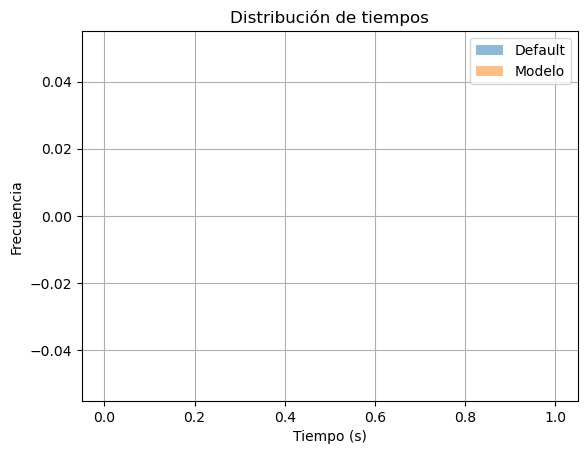

In [17]:
# -------------------------------------------------------
# Histogramas de tiempos
# -------------------------------------------------------
plt.figure()
plt.hist(merged_clean["solving_time_sec_default"], bins=20, alpha=0.5, label="Default")
plt.hist(merged_clean["solving_time_sec_model"], bins=20, alpha=0.5, label="Modelo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Frecuencia")
plt.title("Distribución de tiempos")
plt.legend()
plt.grid(True)
plt.show()
plt.close()


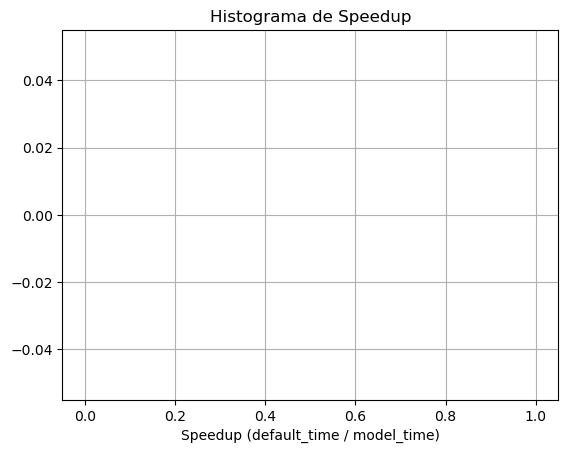

In [18]:
# -------------------------------------------------------
# Histograma de speedup
# -------------------------------------------------------
plt.figure()
plt.hist(merged_clean["speedup"].dropna(), bins=20)
plt.xlabel("Speedup (default_time / model_time)")
plt.title("Histograma de Speedup")
plt.grid(True)
plt.show()
plt.close()


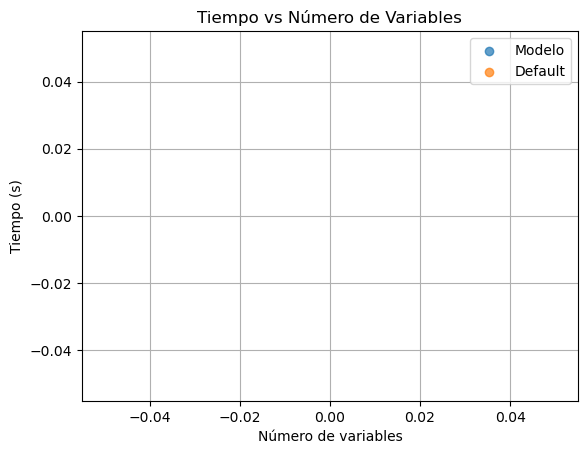

In [19]:
# -------------------------------------------------------
# Tiempo vs número de variables
# -------------------------------------------------------
plt.figure()
plt.scatter(
    merged_clean["n_vars_model"],
    merged_clean["solving_time_sec_model"],
    label="Modelo",
    alpha=0.7
)

plt.scatter(
    merged_clean["n_vars_model"],
    merged_clean["solving_time_sec_default"],
    label="Default",
    alpha=0.7
)

plt.xlabel("Número de variables")
plt.ylabel("Tiempo (s)")
plt.title("Tiempo vs Número de Variables")
plt.legend()
plt.grid(True)
plt.show()
plt.close()
